# Spectral verification + Gershgorin/norm bounds

**NOTE**: This notebook imports NOS modules from src/. See the repository README section “Running notebooks” for setup.

[builder] base W: shape=(120, 120), rho≈1.0000, density≈0.033, deg(min/mean/max)=(2,3.9,21)
f'(v*)=0.1000,  dbar=-0.1000,  k*=0.9333,  Hopf admissible? False
Params: {'alpha': 0.25, 'kappa': 0, 'vstar': 0.2, 'beta': 0.25, 'lam': 0.4, 'chi': 0.05, 'a': 1.0, 'b': 1.0, 'mu': 0.2, 'coupling_through_nonlinearity': False, 'edge_symmetric_sampling': False}

Summary table (bounds are sufficient, not tight):
 ρ(W)  g* (meas.)  ρg* (meas.)  g_bound (k*/||W||∞)  g_bound (k*/||W||2)  k* (scalar)  (ρg*)/k*  Hopf admissible?
  0.5    1.866737     0.933368             0.544451             1.473351     0.933333  1.000037             False
  1.0    0.933468     0.933468             0.272226             0.736676     0.933333  1.000144             False
  1.5    0.622373     0.933560             0.181484             0.491117     0.933333  1.000243             False
  2.0    0.466967     0.933933             0.136113             0.368338     0.933333  1.000643             False
  3.0    0.311268     0.933

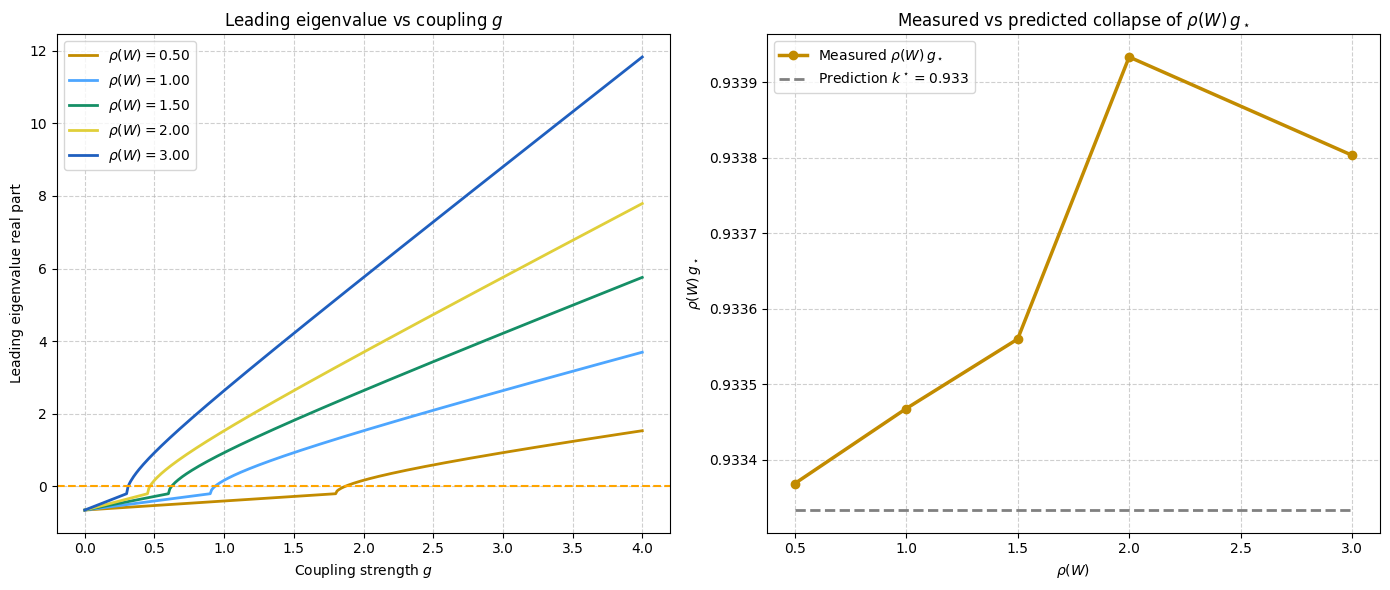


Saved files: /content/outputs/spectral_verification_combined.png, /content/outputs/spectral_verification_table.csv


In [ ]:
import numpy as np
import numpy.linalg as LA
import pandas as pd
import json
import matplotlib.pyplot as plt
import networkx as nx

import sys
from pathlib import Path


CWD0 = Path.cwd()
REPO_ROOT = (CWD0.parent if CWD0.name.lower() == "notebooks" else CWD0)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# Import NOS ground-truth helpers
try:
    from src.nos import NOSParams, f_sat_prime
    from src.topology import spectral_radius, normalise_to_spectral_radius
    from src.linearisation import LinPoint, effective_dbar, block_jacobian, leading_real_part_eig
except Exception:
    from nos import NOSParams, f_sat_prime
    from topology import spectral_radius, normalise_to_spectral_radius
    from linearisation import LinPoint, effective_dbar, block_jacobian, leading_real_part_eig


# Put dependencies in requirements.txt (do not pip install inside the notebook):
#   numpy, pandas, matplotlib, networkx
CWD = Path.cwd()
OUTDIR = (CWD.parent / "outputs") if CWD.name.lower() == "notebooks" else (CWD / "outputs")


COUPLING_THROUGH_NONLINEARITY = False

# Weight sampling note:
# When SYMMETRISE=True, the original code sampled directed weights then averaged W = (W+W^T)/2.
# For a "truly symmetric" positive-weight graph, set EDGE_SYMMETRIC_SAMPLING=True to sample once per undirected edge.
EDGE_SYMMETRIC_SAMPLING = False
# ---------------- Topology builder ----------------
TOPOLOGY    = "scale-free"   # "chain" | "star" | "scale-free"
N           = 120
SEED        = 5

WEIGHTED    = True      # positive, heterogeneous weights
LOGN_SIG    = 0.7
SYMMETRISE  = True      # undirected-like: W = (A + A^T)/2
NORMALISE   = True      # normalise base W so rho(W) ≈ 1

def apply_weights(A, rng, sigma=0.7):
    if not WEIGHTED:
        return A.astype(float)
    W = A.astype(float)
    m = (A != 0)
    W[m] = rng.lognormal(mean=0.0, sigma=sigma, size=m.sum())
    return W

def make_chain(N, rng):
    G = nx.path_graph(N)
    if SYMMETRISE and EDGE_SYMMETRIC_SAMPLING:
        # Sample one weight per undirected edge and mirror it.
        W = np.zeros((N, N), dtype=float)
        for (i, j) in G.edges():
            w = float(rng.lognormal(mean=0.0, sigma=LOGN_SIG))
            W[i, j] = w
            W[j, i] = w
        np.fill_diagonal(W, 0.0)
        return W

    A = nx.to_numpy_array(G, dtype=float); np.fill_diagonal(A, 0.0)
    W = apply_weights(A, rng, LOGN_SIG)
    return 0.5*(W+W.T) if SYMMETRISE else W
def make_star(N, rng):
    G = nx.star_graph(N-1)
    if SYMMETRISE and EDGE_SYMMETRIC_SAMPLING:
        # Sample one weight per undirected edge and mirror it.
        W = np.zeros((N, N), dtype=float)
        for (i, j) in G.edges():
            w = float(rng.lognormal(mean=0.0, sigma=LOGN_SIG))
            W[i, j] = w
            W[j, i] = w
        np.fill_diagonal(W, 0.0)
        return W
    A = nx.to_numpy_array(G, dtype=float); np.fill_diagonal(A, 0.0)
    W = apply_weights(A, rng, LOGN_SIG)
    return 0.5*(W+W.T) if SYMMETRISE else W

def make_scalefree(N, m=2, seed=1, rng=None):
    G = nx.barabasi_albert_graph(N, m, seed=seed)
    A = nx.to_numpy_array(G, dtype=float)
    if SYMMETRISE:
        A = 0.5*(A + A.T)
    np.fill_diagonal(A, 0.0)t
    W = apply_weights(A, rng, LOGN_SIG)
    return W

def build_W_base(topology, N, seed):
    rng = np.random.default_rng(seed)
    if topology == "chain":
        W = make_chain(N, rng)
    elif topology == "star":
        W = make_star(N, rng)
    elif topology == "scale-free":
        W = make_scalefree(N, m=2, seed=seed, rng=rng)
    else:
        raise ValueError("topology must be 'chain' | 'star' | 'scale-free'")
    # normalise to rho≈1 if requested
    vals = LA.eigvals(W); rho = float(np.max(np.abs(vals))) if W.size else 1.0
    if NORMALISE and rho > 0:
        W = W / rho
        vals = LA.eigvals(W); rho = float(np.max(np.abs(vals)))
    degs = np.sum(W!=0, axis=1)
    density = float(np.count_nonzero(W)/W.size)
    print(f"[builder] base W: shape={W.shape}, rho≈{rho:.4f}, density≈{density:.3f}, "
          f"deg(min/mean/max)=({int(degs.min())},{degs.mean():.1f},{int(degs.max())})")
    return W, rho

W_base, rho_base = build_W_base(TOPOLOGY, N, SEED)

# ---------------- NOS linearisation parameters  ----------------
alpha = 0.25
kappa = 0          # set 0.0 for quadratic small-signal
vstar = 0.20
beta  = 0.25
lam   = 0.40
chi   = 0.05
a, b, mu = 1.0, 1.0, 0.20


p = NOSParams(
    alpha=alpha,
    kappa=float(kappa),
    beta=beta,
    gamma=0.0,
    lam=lam,
    chi=chi,
    v_rest=0.0,
    a=a,
    b=b,
    mu=mu,
)
lp = LinPoint(vstar=vstar, coupling_through_nonlinearity=COUPLING_THROUGH_NONLINEARITY)

fprime = float(f_sat_prime(np.array([vstar], dtype=float), p.alpha, p.kappa)[0])
dbar = float(effective_dbar(p, lp))
k_star = min((a + mu) - dbar, (a * b) / (a + mu) - dbar)

hopf_admissible = (a * b > (a + mu) ** 2)  # diagnostic only
print(f"f'(v*)={fprime:.4f},  dbar={dbar:.4f},  k*={k_star:.4f},  Hopf admissible? {hopf_admissible}")


P = dict(alpha=alpha, kappa=kappa, vstar=vstar, beta=beta, lam=lam, chi=chi, a=a, b=b, mu=mu,
         coupling_through_nonlinearity=COUPLING_THROUGH_NONLINEARITY,
         edge_symmetric_sampling=EDGE_SYMMETRIC_SAMPLING)
print("Params:", P)



rhos = [0.5, 1, 1.5, 2.0, 3.0]          # target spectral radii
g_grid = np.linspace(0.0, 4.0, 401)
I = np.eye(N)

def leading_real_eig(J):
    return float(leading_real_part_eig(J))

def find_g_star(g_vec, y_vec):
    # first zero crossing from negative to positive real part
    s = np.sign(y_vec)
    idx = np.where((s[:-1] <= 0) & (s[1:] > 0))[0]
    if idx.size == 0:
        return np.nan
    i = int(idx[0])
    g0, g1 = g_vec[i], g_vec[i+1]
    y0, y1 = y_vec[i], y_vec[i+1]
    return g0 - y0 * (g1 - g0) / (y1 - y0) if y1 != y0 else g0

def J_block(W_eff, dbar, a, b, mu):
    Nn = W_eff.shape[0]; I = np.eye(Nn)
    A11 = dbar*np.eye(Nn) + W_eff
    A12 = -I
    A21 = (a*b)*I
    A22 = -(a+mu)*I
    return np.block([[A11, A12],[A21, A22]])

curves = []
rows = []

for rho_target in rhos:
    # scale the base W to have the requested spectral radius
    eig_base = LA.eigvals(W_base)
    rho_now  = float(np.max(np.abs(eig_base))) if eig_base.size else 1.0
    scale    = (rho_target / rho_now) if rho_now > 0 else 1.0
    W = scale * W_base

    # measured ∞-norm, 2-norm, and spectral radius
    W_inf = float(np.max(np.sum(np.abs(W), axis=1)))
    W_2   = float(LA.svd(W, compute_uv=False)[0])  # spectral norm
    rho_meas = float(np.max(np.abs(LA.eigvals(W))))

    # Re(lambda_max) vs g
    leading_vals = []
    for g in g_grid:
        # Build the (v,u) block Jacobian using src/linearisation.py (paper appendix proxy)

        J = block_jacobian(W=W, k=g, p=p, lp=lp)

        leading_vals.append(leading_real_eig(J))
    leading_vals = np.array(leading_vals)
    curves.append((rho_target, leading_vals))

    g_star_meas = find_g_star(g_grid, leading_vals)

    # Clean sufficient bounds (norm-based):
    # Note: for nonnegative W, ||W||_∞ is a Gershgorin upper bound on ρ(W) (max row-sum).
    #   g <= k*/||W||_∞   and   g <= k*/||W||_2
    g_bound_inf = k_star / W_inf if W_inf > 0 else np.nan
    g_bound_2   = k_star / W_2   if W_2   > 0 else np.nan

    rows.append({
        r'ρ(W)': rho_meas,
        r'g* (meas.)': g_star_meas,
        r'ρg* (meas.)': rho_meas * g_star_meas if np.isfinite(g_star_meas) else np.nan,
        r'g_bound (k*/||W||∞)': g_bound_inf,
        r'g_bound (k*/||W||2)': g_bound_2,
        r'k* (scalar)': k_star,
        r'(ρg*)/k*': (rho_meas * g_star_meas / k_star) if (np.isfinite(g_star_meas) and k_star != 0) else np.nan,
        r'Hopf admissible?': hopf_admissible
    })

df = pd.DataFrame(rows)
pd.set_option('display.precision', 6)
print("\nSummary table (bounds are sufficient, not tight):")
print(df.to_string(index=False))
OUTDIR.mkdir(parents=True, exist_ok=True)

root_export = OUTDIR / "k_star.json"
with open(root_export, "w") as f:
    json.dump(
        {
            "k_star": float(k_star),
            "note": "Scalar margin k* from NOS linearisation (used in rho(W)g* prediction).",
            "params": P,
            "topology": TOPOLOGY,
            "N": int(N),
            "seed": int(SEED),
        },
        f,
        indent=2,
    )
print("[export] wrote", root_export)

# ---------------- Export k* for other appendix notebooks ----------------
# This writes a small JSON file that other notebooks can read (e.g., the Kuramoto appendix marker).
export_dirs = [OUTDIR / "nos_panels", OUTDIR / "kuramoto_synchrony_appendix"]
for _d in export_dirs:
    _d.mkdir(parents=True, exist_ok=True)
    export_path = _d / "k_star.json"
    with open(export_path, "w") as f:
        json.dump(
            {
                "k_star": float(k_star),
                "note": "Scalar margin k* from NOS linearisation (used in rho(W)g* prediction).",
                "params": P,
                "topology": TOPOLOGY,
                "N": int(N),
                "seed": int(SEED),
            },
            f,
            indent=2,
        )
    print("[export] wrote", export_path)
df.to_csv(OUTDIR / 'spectral_verification_table.csv', index=False)

# ---------------- Two-panel figure ----------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Re(λ_max) vs g for each ρ(W)
palette = ['#c28b00', '#4da6ff', '#158f66', '#e0cf3a', '#1f5fbf']
for (rho_target, leading_vals), col in zip(curves, palette):
    axes[0].plot(g_grid, leading_vals, color=col, linewidth=2.0,
                 label=rf'$\rho(W)={rho_target:.2f}$')
axes[0].axhline(0.0, color='orange', linestyle='--', linewidth=1.5)
axes[0].set_xlabel(r'Coupling strength $g$')
axes[0].set_ylabel(r'Leading eigenvalue real part')
axes[0].set_title(r'Leading eigenvalue vs coupling $g$')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# Right: collapse ρ(W) g* (measured) vs k* (scalar prediction)
rho_vals = df[r'ρ(W)'].to_numpy()
rho_g_meas = df[r'ρg* (meas.)'].to_numpy()
axes[1].plot(rho_vals, rho_g_meas, marker='o', color='#c28b00', linewidth=2.5,
             label=rf'Measured $\rho(W)\,g_\star$')
axes[1].hlines(k_star, rho_vals.min(), rho_vals.max(),
               colors='gray', linestyles='--', linewidth=2.0,
               label=rf'Prediction $k^\star={k_star:.3f}$')
axes[1].set_xlabel(r'$\rho(W)$')
axes[1].set_ylabel(r'$\rho(W)\,g_\star$')
axes[1].set_title(r'Measured vs predicted collapse of $\rho(W)\,g_\star$')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

fig.tight_layout()
fig.savefig(OUTDIR / 'spectral_verification_combined.png', dpi=220)
fig.savefig(OUTDIR / 'spectral_verification_combined.pdf')
plt.show()

print('\nSaved files:',
      (OUTDIR / 'spectral_verification_combined.png').as_posix()+',',
      (OUTDIR / 'spectral_verification_table.csv').as_posix())
